Learning `scan` - it's in the LGT time series example and it looks really powerful.

In the context of time series models, `scan` is helpful because it allows us to iterate over sequences (without a cumbersome `for` loop) while maintaining state across each iteration. 

Here are components of the `scan` function:

1. **Input Function**: `scan` takes an input function $f$ that defines the computation you want to perform at each step. This function typically takes two arguments:
   1. `carry`: A tuple that represents the state or context at the current time step. This is passed from one iteration to the next, allowing you to maintain and update state across time steps.
   2. `x`: The current element from the input sequence or array.
2. **Initial State (init)**: You also provide an initial state or `carry`` value. This is the state that the computation starts with at the first time step.
3. **Sequencing**: The `scan` function applies the provided function to each element in the input sequence in order, passing the current carry value and the current element x to the function. It iterates over the entire sequence.
4. **Aggregation**: The output of the function at each time step can be used to produce an output sequence, and the final `carry` value at the last time step can represent the final state. The resulting sequences or values can be collected and returned.

 

The Input function also returns two items:

1. The carried over value(s), aka the latest state
2. An array, where each element is something returned from the Input Function `f` as it passes each element in `xs`



## Trivial Example

In [206]:
import jax.numpy as jnp
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
from jax import random

## Trival Example - CumSum

* [From The Differential Programming Tutorial - Loopy Carry, by Eric Ma](https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html)



In [207]:
# import jax.numpy as np

a = jnp.array([1, 2, 3, 5, 7, 11, 13, 17])

result = []
res = 0
for el in a:
    res += el
    result.append(res)
jnp.array(result)

Array([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

This is identical to the cumulative sum:

In [208]:
jnp.cumsum(a)

Array([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

Now, instead of a for loop, we rewrite it using lax.scan:

In [209]:
from jax import lax

def cumsum(res, el):
    """
    Parameters
    ----------
    res : tuple
        A tuple - the result from the previous loop, aka the 'carry'
    el
        The current array element, also `x`
    """
    res += el
    return res, res # ('carryover', 'accumulated')

result_init = 0
final, result = lax.scan(cumsum, result_init, a)
print(final)
print(result)

59
[ 1  3  6 11 18 29 42 59]


## Trivial Example 2: A little more of the carry function



In [210]:
# Define a function to apply at each time step
def interest_growth(value, x):
    value = value * 1.04
    return 5.0, value # ('carried over value', 'accumulated array')

# Define the initial state and input sequence
init_state = 100.0
T = jnp.array([1, 2, 3, 4, 5])

# Apply the scan function
# scan(f, init, xs, length=None, reverse=False, history=1)
final_state, results = scan(f=interest_growth, init=init_state, xs=T)

print(final_state)
print(results)

5.0
[104.    5.2   5.2   5.2   5.2]


## AR(2) Example

* [Example: AR2 process (numpyro docus)](https://num.pyro.ai/en/stable/examples/ar2.html#sphx-glr-download-examples-ar2-py)

Below I'll follow and document the AR2 example from the numpyro docs.

Given a univariate sequence of data:

$$
y_0, y_1, \dots, y_T
$$

We seek parameters $c$, $\alpha_1$, and $\alpha_2$ such that for each $t$ between $2$ and $T$, we have:

$$
y_t = c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2)
$$


We can restate this as:

$$
\begin{aligned}
y_t &\sim \mathcal{N}(\mu_t, \sigma)\\
\mu_t &= c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2}\\
c &\sim \mathcal{N}(0,1)\\
\alpha_1 &\sim \mathcal{N}(0,1)\\
\alpha_2 &\sim \mathcal{N}(0,1)\\
\sigma &\sim \text{HalfNormal}(1)\\
\end{aligned}
$$

In [211]:
import numpyro 
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import arviz as az

def ar2_scan(y):
    """
    Bayesian autoregressive (AR) model of order 2
    """
    alpha_1 = numpyro.sample("alpha_1", dist.Normal(0, 1))  # lag 1 AR coef
    alpha_2 = numpyro.sample("alpha_2", dist.Normal(0, 1))  # lag 2 AR coef
    const = numpyro.sample("const", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    def transition(carry, _):
        y_prev, y_prev_prev = carry
        m_t = const + alpha_1 * y_prev + alpha_2 * y_prev_prev
        y_t = numpyro.sample("y", dist.Normal(m_t, sigma))
        carry = (y_t, y_prev)
        return carry, None

    timesteps = jnp.arange(y.shape[0] - 2)  # input into xs param in scan()
    init = (y[1], y[0])

    with numpyro.handlers.condition(data={"y": y[2:]}):
        scan(f=transition, init=init, xs=timesteps)
    
    # Alternative using a `for` loop:
    
    # y_prev = y[1]
    # y_prev_prev = y[0]

    # for i in range(2, len(y)):
    #     m_t = const + alpha_1 * y_prev + alpha_2 * y_prev_prev
    #     y_t = numpyro.sample("y_{}".format(i), dist.Normal(m_t, sigma), obs=y[i])
    #     y_prev_prev = y_prev
    #     y_prev = y_t    


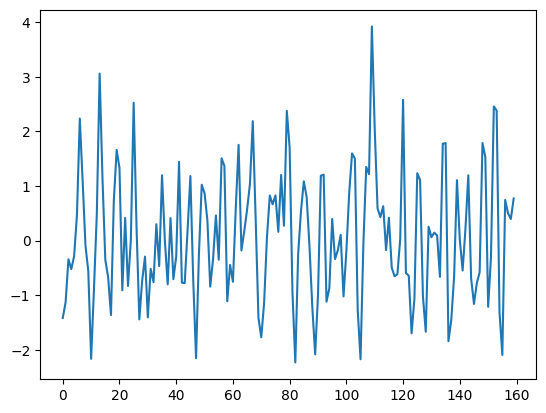

In [212]:
# constants
num_data = 160
rng_key = random.PRNGKey(42)
# Sim Data
from statsmodels.tsa.arima_process import ArmaProcess

t = jnp.arange(0, num_data)

# Generate an AR(2) model with coef 1.3, 0.7 and a constant
ar_coef = jnp.array([1, -0.5, 0.4])
ma_coef = jnp.array([1])
arproc = ArmaProcess(ar_coef, ma_coef)

y = arproc.generate_sample(num_data)
y = jnp.array(y)

# look at the data real quick:
plt.plot(t, y)

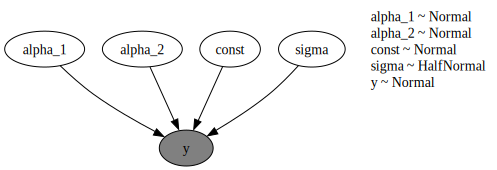

In [213]:
# Render the model so far
numpyro.render_model(ar2_scan, model_args=(y,), render_distributions=True)

In [214]:
# Inference
sampler = NUTS(ar2_scan)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=1)
mcmc.run(rng_key, y=y)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1440.35it/s, 7 steps of size 7.40e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_1      0.44      0.07      0.44      0.33      0.56    961.76      1.00
   alpha_2     -0.42      0.07     -0.42     -0.54     -0.31    795.33      1.00
     const      0.10      0.08      0.10     -0.04      0.24    904.22      1.00
     sigma      1.02      0.06      1.01      0.93      1.12    964.47      1.00

Number of divergences: 0


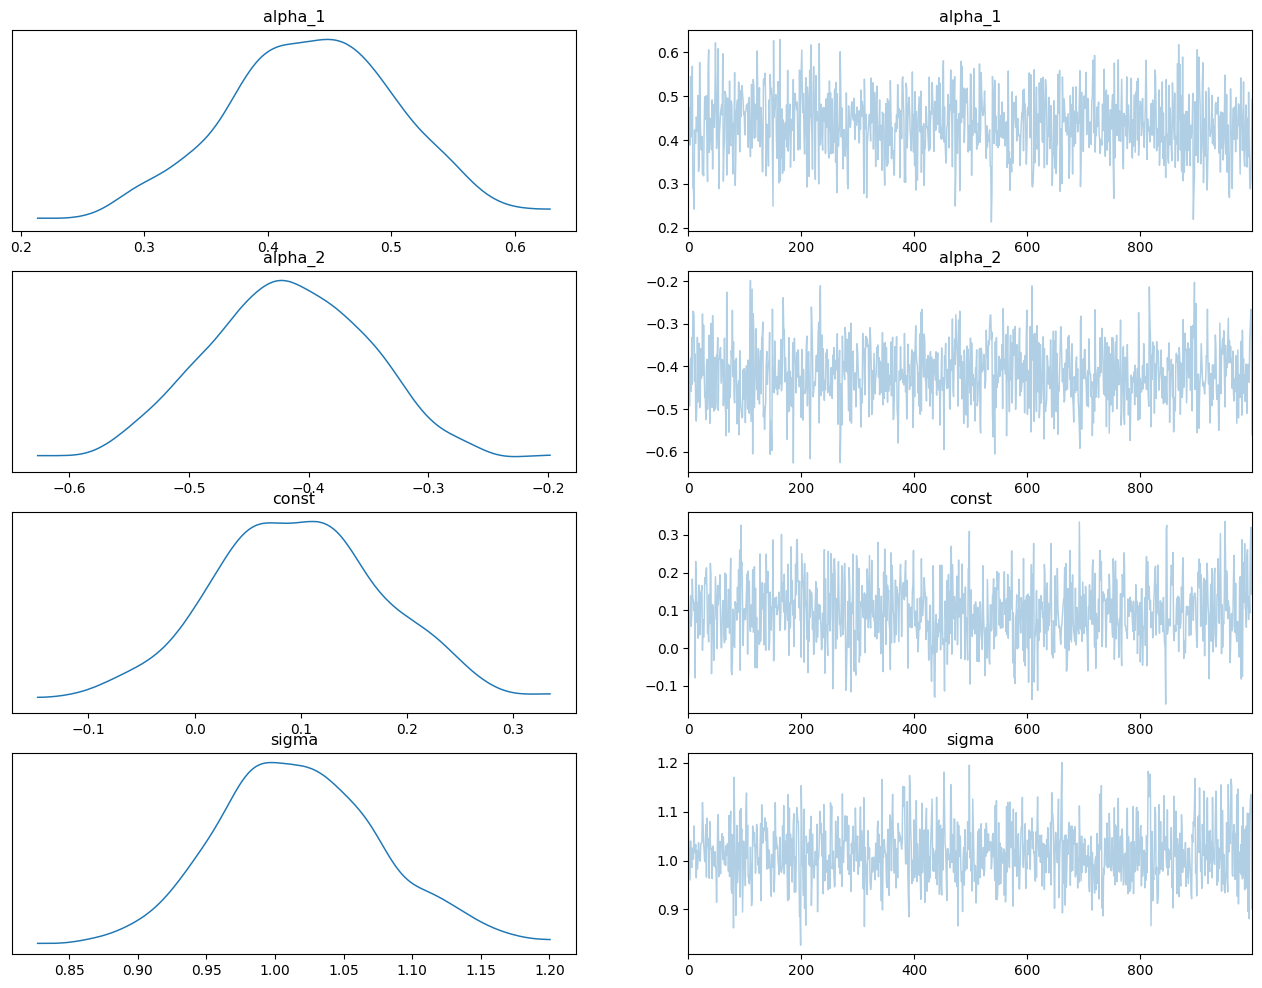

In [215]:
# Get data out as an xarray using arviz .from_numpyro() method
data = az.from_numpyro(mcmc)
# useful plot
az.plot_trace(data, compact=True, figsize=(16,12));

## AR(2) Statsmodels 


In [216]:
import pandas_datareader as pdr
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [217]:
import numpy as np
mod = AutoReg(np.array(y), 2, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  160
Model:                     AutoReg(2)   Log Likelihood                -224.487
Method:               Conditional MLE   S.D. of innovations              1.002
Date:                Thu, 19 Oct 2023   AIC                            456.974
Time:                        13:42:01   BIC                            469.224
Sample:                             2   HQIC                           461.949
                                  160                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0972      0.080      1.214      0.225      -0.060       0.254
y.L1           0.4425      0.072      6.158      0.000       0.302       0.583
y.L2          -0.4255      0.072     -5.950      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


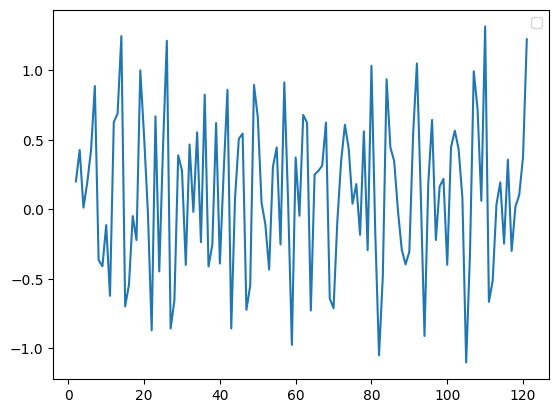

In [218]:
fig = res.plot_predict(0, 121)

## Local Level model

Essentially a random walk, or a regression model in which the intercept changes over time

$$
\begin{aligned}
y_t &= \mu_t + \epsilon_t, & \epsilon_t \sim N(0, \sigma_\epsilon^2)\\ 
\mu_{t+1} &= \mu_t + \xi_t, & \xi_t \sim N(0, \sigma_\xi^2)
\end{aligned}
$$

In [317]:
def local_level(y):
    T = len(y)

    # State space model parameters
    sigma_level = numpyro.sample("sigma_level", dist.HalfCauchy(1.0))
    sigma_obs = numpyro.sample("sigma_obs", dist.HalfCauchy(1.0))
    level_0 = numpyro.sample("level_0", dist.Normal(y[0], 1.0))

    def transition_fn(carry, t):
        level_t = carry
        # State Transition
        level_t = numpyro.sample(f"level", dist.Normal(level_t, sigma_level))
        # Observation equation
        y_t = numpyro.sample("y", dist.Normal(level_t, 1.0))
        
        return level_t, None

    N = y.shape[0]
    with numpyro.handlers.condition(data={"y": y}):
        _, ys = scan(
            transition_fn, init=level_0, xs=jnp.arange(0, N)
        )

Here we use the `condition` handler so that we only `scan` over all the values of `y` except for the first one, because we're using 

## render model

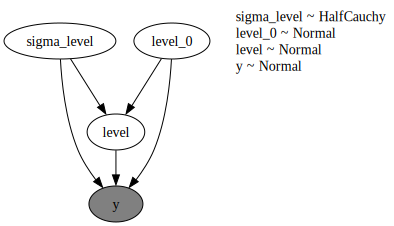

In [318]:
numpyro.render_model(local_level, model_args=(y,), render_distributions=True)

In [320]:
# sim data with numpy
np.random.seed(69)

T = 100
current_level = 0
result = []
for t in range(T):
    current_level += np.random.normal()
    result.append(current_level)

In [321]:
# sim data with jax

rng_key_ = random.PRNGKey(0)

# make an array of errors, and then we'll iterate over them
errors = dist.Normal().sample(rng_key_, (T,))

def simulate_local_level(carry, x):
    current_level = carry
    current_level = current_level + x
    return current_level, current_level

final_state, y = scan(simulate_local_level, init=0, xs=errors)
print(y)

[-1.98107028e+00 -9.32897925e-01 -4.30788398e-02 -7.91283697e-03
 -9.55271363e-01 -1.04014814e-01 -7.27693141e-02 -4.62455243e-01
 -4.49247241e-01 -8.69769156e-01 -2.10333467e+00 -3.35576582e+00
 -2.36837816e+00 -1.56242430e+00 -1.97325468e+00 -9.99433577e-01
 -1.68733859e+00 -2.48039055e+00 -4.45366240e+00 -4.29827404e+00
 -4.87913322e+00 -3.29283142e+00 -3.00790429e+00 -2.36967158e+00
 -2.30897880e+00 -1.91102660e+00 -2.13824320e+00 -2.84362459e+00
 -2.18655872e+00 -3.99268484e+00 -2.95189238e+00 -4.92318344e+00
 -4.99242830e+00 -4.38845873e+00 -4.77228308e+00 -4.44726276e+00
 -4.16592216e+00 -5.67799759e+00 -4.80307150e+00 -5.59885693e+00
 -5.22288179e+00 -5.67802954e+00 -5.54253817e+00 -4.34227848e+00
 -2.60170174e+00 -1.61311030e+00 -1.64019942e+00 -2.82470846e+00
 -3.78151894e+00 -2.80105782e+00 -2.57992625e+00 -2.09338379e+00
 -3.95635247e-01 -1.94323123e-01 -7.76444852e-01 -1.16854632e+00
 -1.11846757e+00  9.60213184e-01  1.12285078e+00  4.31414247e-01
  9.19420481e-01  2.68968

In [322]:
## Prior Predictive
num_samples = 50
prior_predictive = Predictive(local_level, num_samples=num_samples)
prior_predictions = prior_predictive(rng_key, y)['y']

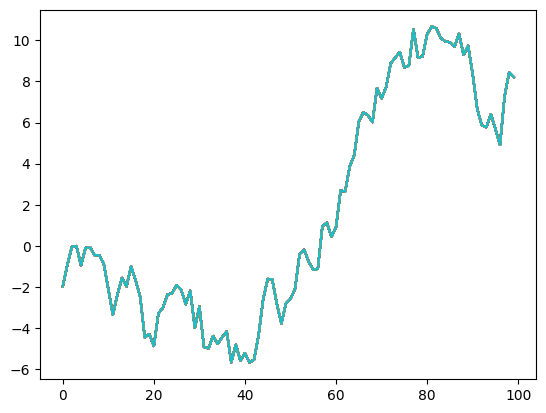

In [323]:
x = range(T)
for i in range(num_samples):
    plt.plot(x, prior_predictions[i])

In [324]:
# Inference
kernel = NUTS(local_level)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000)
mcmc.run(rng_key, y)

mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1452.96it/s, 15 steps of size 3.44e-01. acc. prob=0.80]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     level[0]     -1.46      0.60     -1.45     -2.42     -0.52   1180.96      1.00
     level[1]     -1.02      0.57     -1.03     -1.94     -0.03   1163.73      1.00
     level[2]     -0.58      0.61     -0.61     -1.47      0.50   1222.74      1.00
     level[3]     -0.43      0.57     -0.44     -1.44      0.45   1062.62      1.00
     level[4]     -0.52      0.55     -0.55     -1.47      0.31   1201.39      1.00
     level[5]     -0.37      0.55     -0.35     -1.30      0.48   1305.49      1.00
     level[6]     -0.40      0.58     -0.37     -1.36      0.53   1205.86      1.00
     level[7]     -0.58      0.59     -0.58     -1.60      0.33   1157.47      1.00
     level[8]     -0.83      0.56     -0.82     -1.81     -0.00   1093.01      1.00
     level[9]     -1.24      0.53     -1.26     -2.07     -0.30   1203.00      1.00
    level[10]     -1.80      0.56     -1.84     -2.72     -0.93   1154.15  

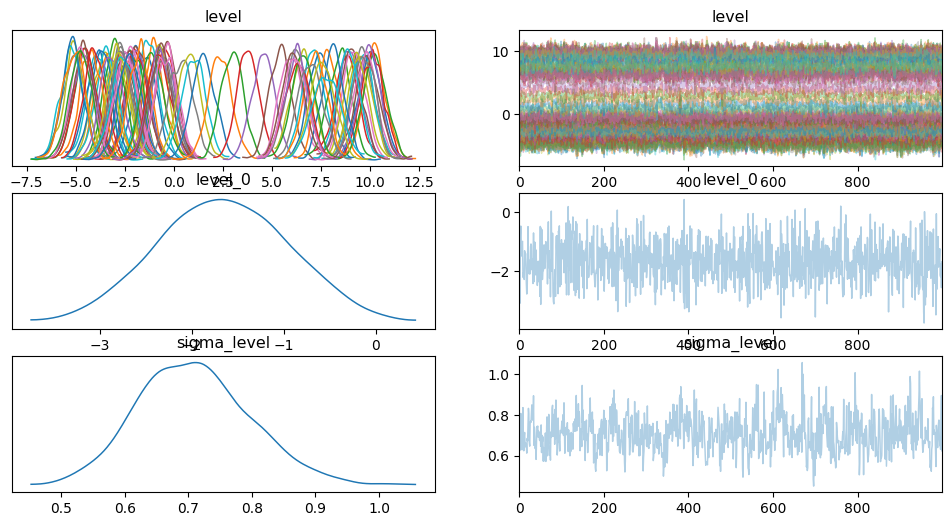

In [325]:
# useful plot
az.plot_trace(mcmc, compact=True);

In [311]:
# Get posterior samples
samples = mcmc.get_samples()

# Extract posterior means of parameters and states
posterior_mean_level = jnp.mean(samples["level"], axis=0)
posterior_mean_sigma_level = jnp.mean(samples["sigma_level"])

print("Posterior Mean Level:", posterior_mean_level)
print("Posterior Mean Sigma Level:", posterior_mean_sigma_level)

Posterior Mean Level: [-0.95880723 -0.74773484 -0.46645415 -0.37879488 -0.48058614 -0.370212
 -0.39240918 -0.57588685 -0.80415225 -1.2363077  -1.8078532  -2.25385
 -2.1433403  -1.9208612  -1.8810416  -1.8481321  -2.2086012  -2.7808967
 -3.5460424  -3.8406277  -3.8876956  -3.4328449  -3.0380993  -2.6691751
 -2.460659   -2.3530085  -2.4401593  -2.7006967  -2.8951564  -3.410752
 -3.6304424  -4.2268667  -4.488044   -4.517245   -4.617995   -4.6464734
 -4.7043715  -5.049585   -5.0548186  -5.202341   -5.19213    -5.123625
 -4.784007   -4.034505   -3.1841276  -2.5542452  -2.428347   -2.672917
 -2.8446314  -2.5896685  -2.25126    -1.7428997  -1.0812944  -0.75969
 -0.71978974 -0.64814895 -0.3439653   0.36018255  0.7839623   1.0331792
  1.5336078   2.358552    2.984734    3.7752035   4.559381    5.4321475
  5.966458    6.2855988   6.5692573   7.138953    7.44072     7.9174395
  8.488674    8.830533    9.013699    9.010405    9.205969    9.598139
  9.516393    9.64914     9.995424   10.242039   10

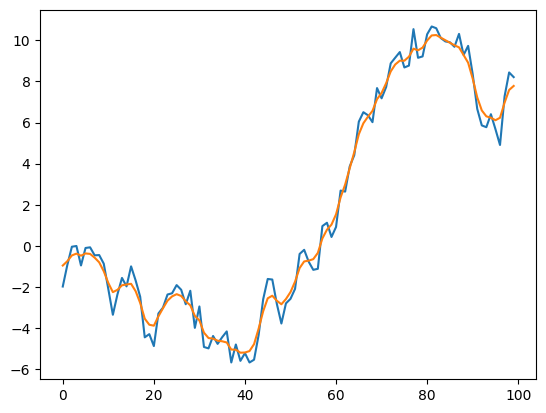

In [326]:
plt.plot(np.arange(T), y)
plt.plot(np.arange(0,T), posterior_mean_level)